In [77]:
import open3d as o3d
import pyrealsense2 as rs

In [71]:

# === open3d === #

import os
import open3d.ml as _ml3d
#import open3d.ml.torch as ml3d

cfg_file = "ml3d/configs/pointpillars_kitti.yml"
cfg = _ml3d.utils.Config.load_from_file(cfg_file)

model = ml3d.models.PointPillars(**cfg.model)
cfg.dataset['dataset_path'] = "/path/to/your/dataset"
dataset = ml3d.datasets.KITTI(cfg.dataset.pop('dataset_path', None), **cfg.dataset)
pipeline = ml3d.pipelines.ObjectDetection(model, dataset=dataset, device="gpu", **cfg.pipeline)

... 
# run inference on a single example.
result = pipeline.run_inference(data)

FileNotFoundError: File ml3d/configs/pointpillars_kitti.yml not found

In [78]:

# === pytorch - yolo === #

#from IPython.display import display
from PIL import Image
import time
import torch

#config_path = "/usr/local/lib/python3.8/dist-packages/yolo/yolov3.cfg" # the YOLO net weights file
#weights_path = "/usr/local/lib/python3.8/dist-packages/yolo/yolov3.weights" # weights_path = "weights/yolov3-tiny.weights"
#labels_path = "/usr/local/lib/python3.8/dist-packages/yolo/data/coco.names"
img_path2 = "/home/physine/Documents/FYP/images/original.jpg" # crowded sence
img_path1 = "/home/physine/Documents/FYP/images/single_biker.jpg" # single biker

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
def run_obj_detect_model(img):
    object_list = []
    results = model(img)
    df = results.pandas().xyxy[0]
    t0 = time.time()
    for index, row in df.iterrows():
        # xmin,   ymin,   xmax,   ymax,   confidence, objectName
        # row[0], row[1], row[2], row[3], row[4],     row[6]
        object_list.append(row)      
    print(f'infrance time of img: {time.time()-t0}')
    return object_list
     
def array_to_img(array):
    return Image.fromarray(array)
    
imgs = [
    "/home/physine/Documents/FYP/images/original.jpg",
    "/home/physine/Documents/FYP/images/single_biker.jpg"
]

# for img in imgs:
#     print('===========================================================')
#     objects = run_model(img)
#     for obj in objects:
#         print('-------------------------------------------------------------')
#         print(f'xmin =\t{obj[0]} \nymin =\t{obj[1]} \nxmax =\t{obj[2]} \nymax =\t{obj[3]} \nconfidence =\t{obj[4]} \nobjectName =\t{obj[6]}')

Using cache found in /home/physine/.cache/torch/hub/ultralytics_yolov5_master
INFO - 2021-11-13 18:59:56,301 - torch_utils - YOLOv5 🚀 2021-11-3 torch 1.7.1 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3011.375MB)

INFO - 2021-11-13 18:59:57,375 - yolo - Fusing layers... 
INFO - 2021-11-13 18:59:57,491 - torch_utils - Model Summary: 213 layers, 7225885 parameters, 0 gradients
INFO - 2021-11-13 18:59:57,492 - yolo - Adding AutoShape... 


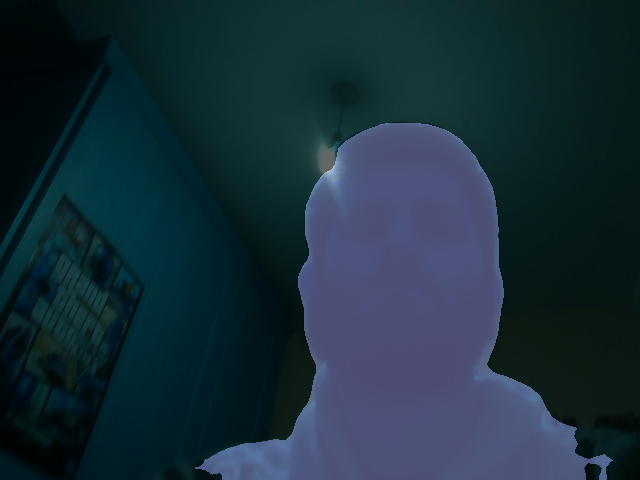

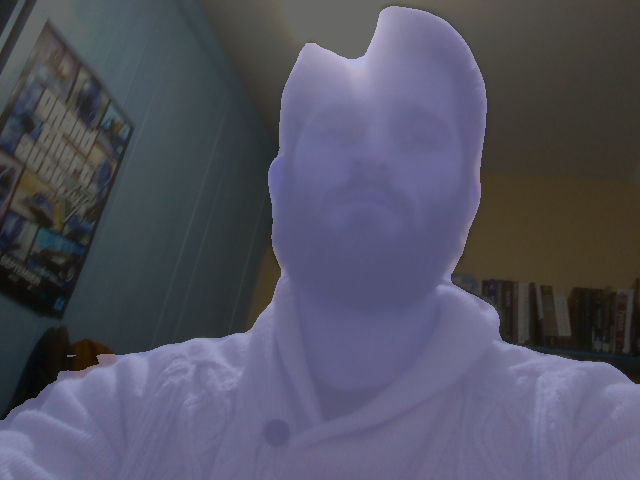

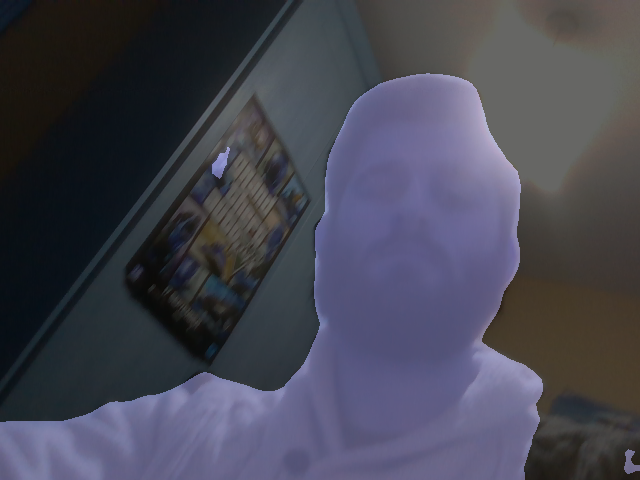

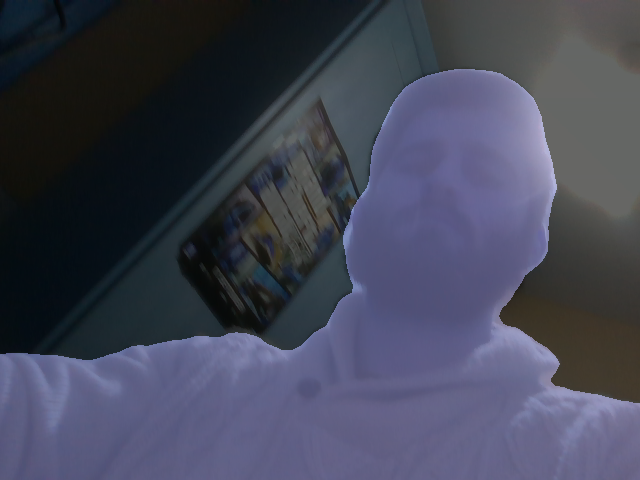

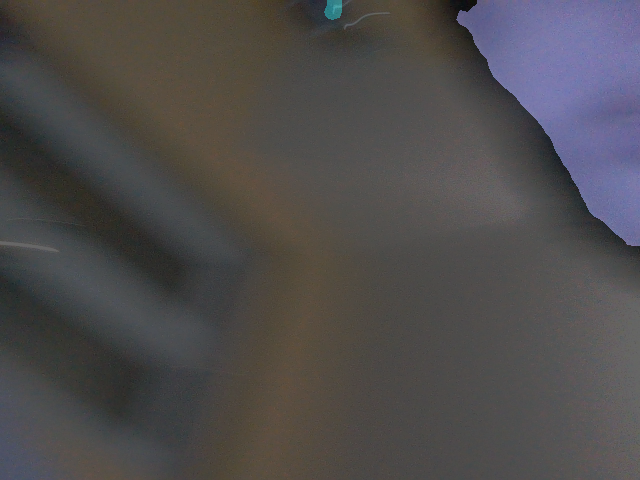

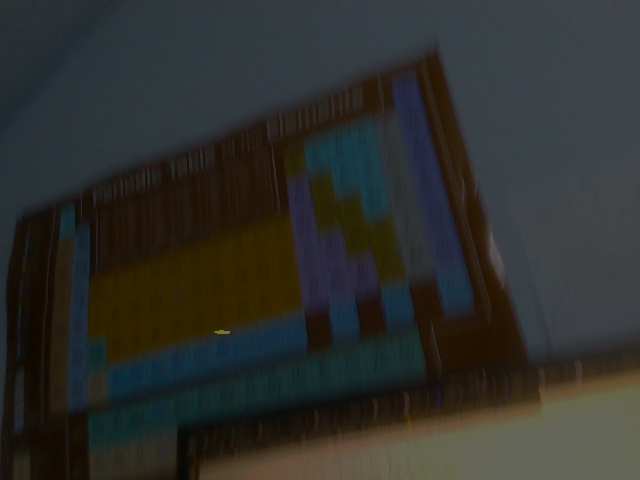

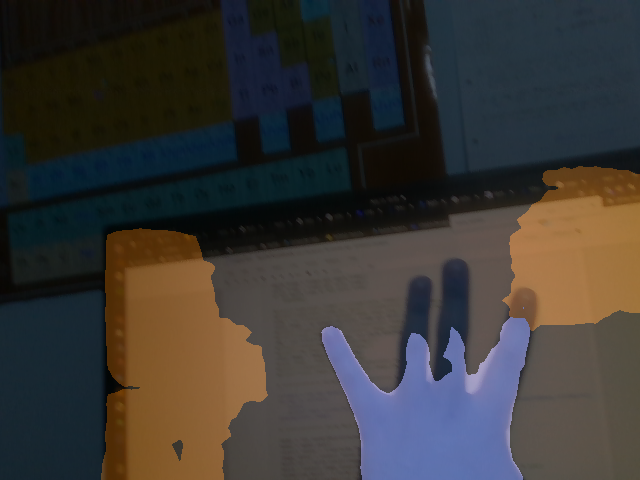

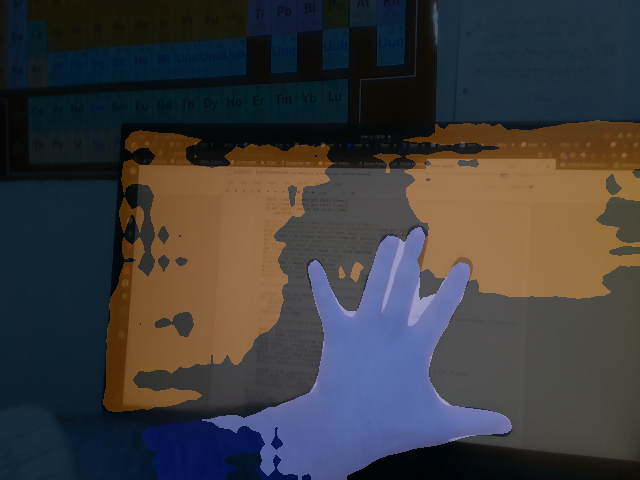

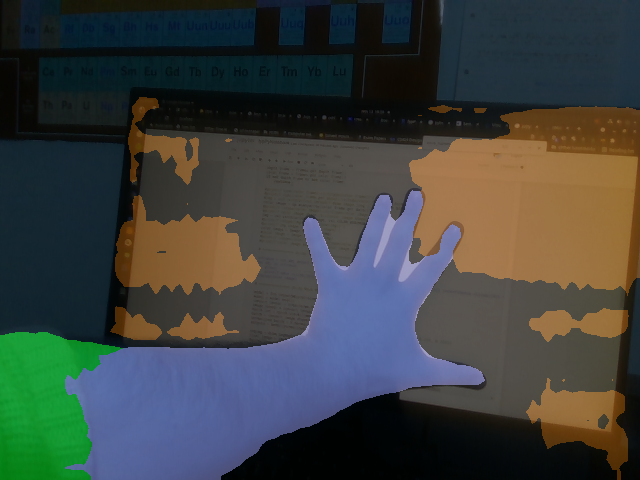

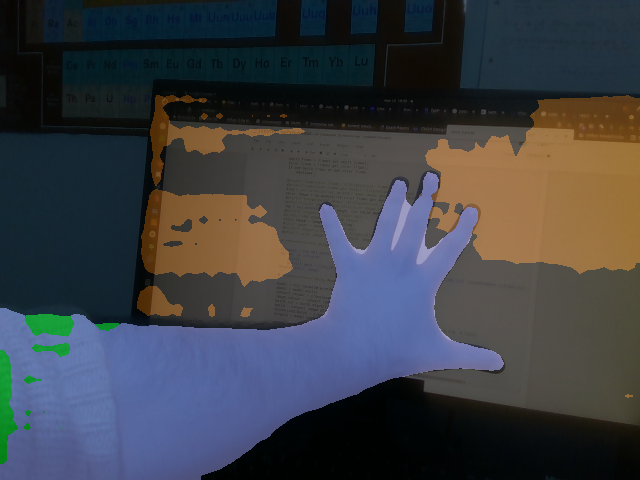

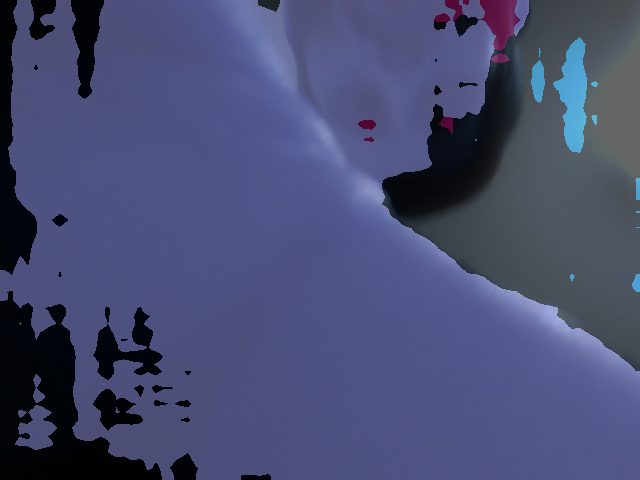

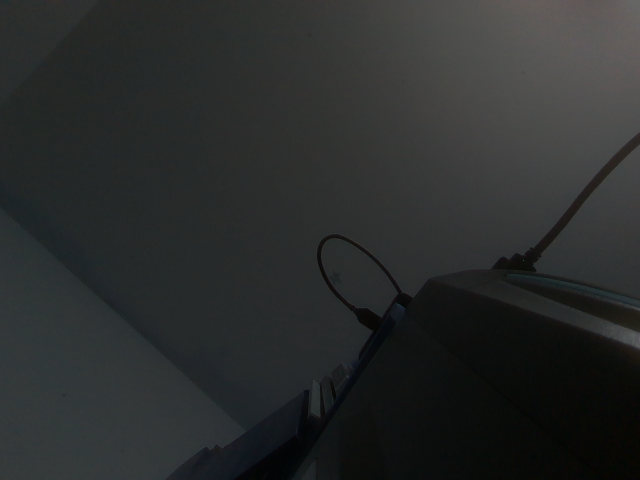

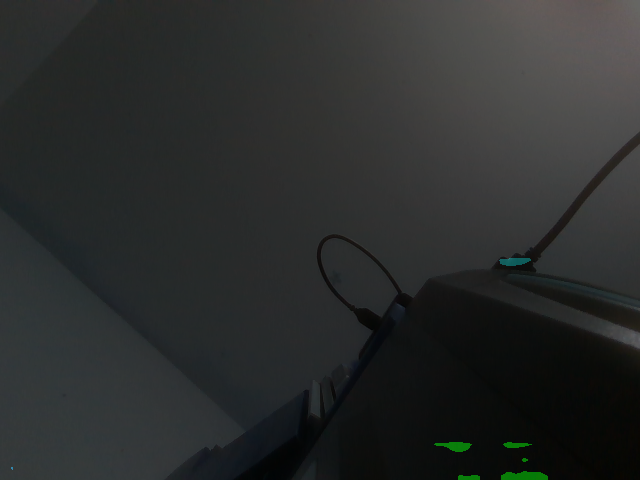

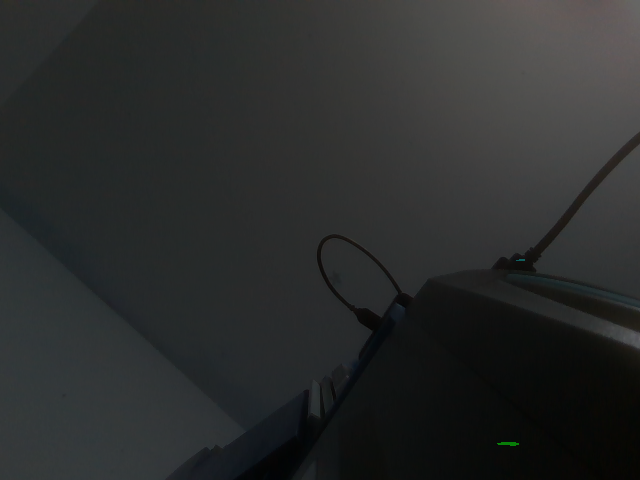

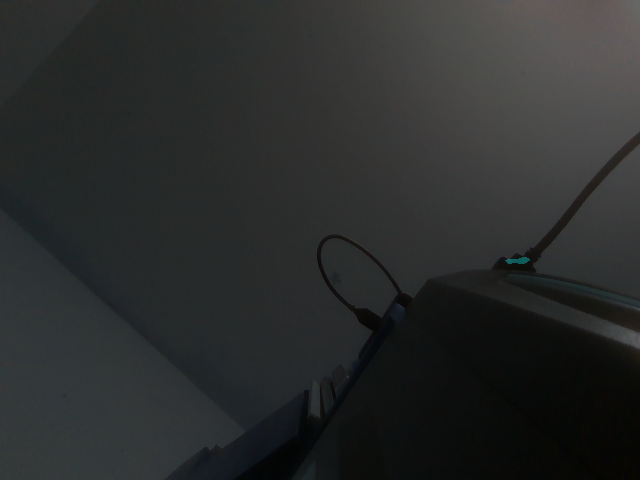

OK


In [115]:

# === pyrealsense2 === #

import torch
import cv2
import numpy as np
from PIL import Image
import torchvision
from torchvision.models.segmentation import fcn_resnet50
import torchvision.transforms.functional as F
from torchvision.transforms.functional import convert_image_dtype
#from torchvision.utils import draw_bounding_boxes

### ===================== stuff used for Mask R-CNN (start) ===================== ###

label_map = [
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus 
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)
    
    for label_num in range(0, len(label_map)):
        index = labels == label_num
        red_map[index] = np.array(label_map)[label_num, 0]
        green_map[index] = np.array(label_map)[label_num, 1]
        blue_map[index] = np.array(label_map)[label_num, 2]
        
    segmented_image = np.stack([red_map, green_map, blue_map], axis=2)
    return segmented_image

def get_segment_labels(image, model, device):
    # transform the image to tensor and load into computation device
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image)
    # uncomment the following lines for more info
    # print(type(outputs))
    # print(outputs['out'].shape)
    # print(outputs)
    return outputs

def image_overlay(image, segmented_image):
    alpha = 0.6 # how much transparency to apply
    beta = 1 - alpha # alpha + beta should equal 1
    gamma = 0 # scalar added to each sum
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(segmented_image, alpha, image, beta, gamma, image)
    return image

### ===================== stuff used for Mask R-CNN (end) ===================== ###

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

color_path = 'V00P00A00C00_rgb.avi'
depth_path = 'V00P00A00C00_depth.avi'
colorwriter = cv2.VideoWriter(color_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (640,480), 1)
depthwriter = cv2.VideoWriter(depth_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (640,480), 1)

pipeline.start(config)

for _ in range(15):
    import time
    time.sleep(.1)
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    if not depth_frame or not color_frame:
        continue
        
    #print(f'type(color_frame):\t\t{type(color_frame)}')
    #print(f'type(color_frame.get_data():\t{type(color_frame.get_data())}')
    #img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
    color_image = np.asanyarray(color_frame.get_data())
    #print(f'\ntype(color_image):\t\t{type(color_image)}')
    #print(f'color_image.shape:\t\t{color_image.shape}')
    img = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    #print(f'\ntype(img):\t\t\t{type(img)}')
    #print(f'img.shape:\t\t\t{img.shape}')
    color_image = Image.fromarray(img)
    #color_image = Image.fromarray(img)
    #print(f'\ntype(color_image):\t\t{type(color_image)}')
    #print(f'color_image.shape:\t\t{color_image.shape}')
    
    # =============== Using YOLO =============== #
    '''
    infrance = run_obj_detect_model(color_image)    
    for obj in infrance:
        print('-------------------------------------------------------------')
        print(f'xmin =\t{obj[0]} \nymin =\t{obj[1]} \nxmax =\t{obj[2]} \nymax =\t{obj[3]} \nconfidence =\t{obj[4]} \nobjectName =\t{obj[6]}')
    display(color_image)    
    '''
    # =============== Using Mask R-CNN =============== #    

    model = fcn_resnet50(pretrained=True, progress=False)
    model = model.eval()
    convert_tensor = transforms.ToTensor()
    image_tensor = convert_tensor(color_image)
    batch_int = torch.stack([image_tensor])
    batch = convert_image_dtype(batch_int, dtype=torch.float)  
    normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    outputs = model(normalized_batch)['out']
    
    segimg = draw_segmentation_map(outputs)
    final_image = image_overlay(color_image, segimg)
    #print(type(final_image))
    display(Image.fromarray(final_image))
    
print('OK')
pipeline.stop()